In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir("/content/drive/MyDrive/Road_Analysis")

In [3]:
!ls
!pip install einops
!pip install git+https://github.com/sberbank-ai/Real-ESRGAN.git
!conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia
# !pip install ITTR-pytorch


 city.mp4			      Project.ipynb		      train
 Descriminator.py		      Project_noseq.ipynb	      val
 ITTR_pytorch.py		      Project_UNet.ipynb	      video1.mp4
 ITTR_transformer_NoSeqEmb.py	      __pycache__		      video2.mp4
 ITTR_transformer.py		      rulral.mp4		      video3.mp4
 ITTR_transformer_random_shuffle.py   saved_model_basline.pth	      video4.mp4
 ITTR_transformer_UNet.py	      saved_model_discriminator.pth   video5.mp4
 LSTM_video_pred.py		      saved_model_noseq.pth	      video_dataset.py
 mountain.mp4			      saved_model.pth		      weights
 preprocessing.py		      saved_model_UNet.pth	     '프로젝트 블루 프린트.gdoc'
 Project_CPU.ipynb		      test
  Cloning https://github.com/sberbank-ai/Real-ESRGAN.git to /tmp/pip-req-build-dtft_dfa
  Running command git clone --filter=blob:none --quiet https://github.com/sberbank-ai/Real-ESRGAN.git /tmp/pip-req-build-dtft_dfa
  Resolved https://github.com/sberbank-ai/Real-ESRGAN.git to commit 362a0316878f41dbdfbb23657b450c3353de5ac

In [4]:
import preprocessing
import ITTR_transformer
import video_dataset
import torch as nn
# from ITTR_transformer import TransformerCNNForSegmentation
from ITTR_transformer import ModifiedTransformerCNNForSegmentation
from video_dataset import VideoDatasetMaker
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from tqdm import tqdm
import numpy as np
import cv2
from RealESRGAN import RealESRGAN

def sharpening(image):
  image = image.detach().numpy()
  kernel = np.array([[-1, -1, -1],
                    [-1,  9, -1],
                    [-1, -1, -1]])

  # 이미지에 커널 적용하기
  sharpened_image = cv2.filter2D(image, -1, kernel)
  return sharpened_image

In [5]:
# video_files = ['mountain.mp4', 'city.mp4','video1.mp4', 'video2.mp4', 'video3.mp4', 'video4.mp4', 'video5.mp4']

# extractor = VideoDatasetMaker(video_files = video_files, train_size=40000, val_size=1000, test_size=1000)
# extractor.run()

In [6]:

def show_samples(dataset, num_samples=2):
    for i in range(num_samples):

        input_frames, label_frame = dataset[i]
        # 인풋 프레임을 시각화합니다.
        # input_frames는 [4, 3, 224, 224]의 형태를 가지므로, make_grid를 사용하여 모든 프레임을 하나의 그리드로 만듭니다.
        input_grid = make_grid(input_frames, nrow=4)  # 4개의 프레임을 한 줄로 배치
        plt.figure()
        plt.imshow(input_grid.permute(1, 2, 0))
        plt.title(f'Input Frames {i+1}')
        plt.axis('off')
        plt.show()

        # 라벨 프레임을 시각화합니다.
        # label_frame은 [3, 224, 224]의 형태를 가지므로, 직접 시각화합니다.
        plt.figure()
        plt.imshow(label_frame.permute(1, 2, 0))
        plt.title(f'Label Frame {i+1}')
        plt.axis('off')
        plt.show()

In [7]:
device = nn.device("cuda:0" if nn.cuda.is_available() else "cpu")

In [8]:
import torch as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import glob

class VideoFramesDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        root_dir: 프레임이 저장된 디렉토리 경로
        transform: 이미지에 적용할 변환 (옵션)
        """
        self.root_dir = root_dir
        self.transform = transform
        # 모든 프레임 파일의 경로를 정렬하여 로드
        self.frames = sorted(glob.glob(f"{root_dir}/*.png"))

    def __len__(self):
        # 마지막 4개의 프레임은 첫 번째 입력으로 사용되므로, 전체 길이에서 4를 뺀다
        return len(self.frames) // 5

    def __getitem__(self, idx):
    # 프레임 세트의 시작 인덱스를 계산
    # 각 세트는 5개의 프레임으로 구성되므로, idx를 세트 크기로 곱합니다.
      start_idx = idx * 5  # 여기서 5는 세트당 프레임 수

      # 연속된 5개의 프레임을 선택
      frames = [Image.open(self.frames[start_idx + i]) for i in range(5)]

      if self.transform:
          # 모든 프레임에 대해 변환 적용
          frames = [self.transform(frame) for frame in frames]

      # 4개의 프레임을 스택하여 입력 데이터로 구성
      input_frames = nn.stack(frames[:-1])
      # 마지막 프레임을 라벨로 사용
      label_frame = frames[-1]

      return input_frames, label_frame

# 이미지 변환 정의
# 이미지 크기를 224x224로 조정하고, 텐서로 변환
x = 224
y = 224
transform = transforms.Compose([
    transforms.Resize((y, x)),  # 이미지 크기 조정
    transforms.ToTensor(),  # 텐서로 변환
])

# 데이터셋 인스턴스 생성
train_dataset = VideoFramesDataset(root_dir='train', transform=transform)
valid_dataset = VideoFramesDataset(root_dir='val', transform=transform)
test_dataset = VideoFramesDataset(root_dir='test', transform=transform)

batch_size = 8
# DataLoader 인스턴스 생성
data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

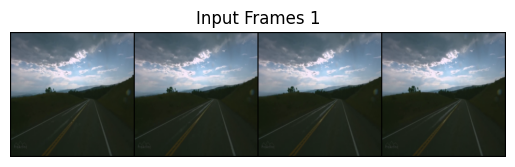

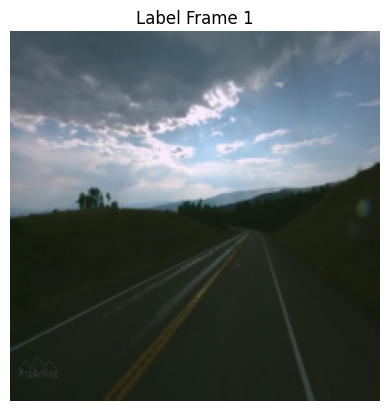

In [9]:
show_samples(test_dataset, num_samples=1)

In [9]:
import torch.optim as optim
from Descriminator import Discriminator
from torchvision.transforms.functional import to_pil_image
from ITTR_transformer_random_shuffle import ITTRTransformerCNN_random_shuffle

model = ModifiedTransformerCNNForSegmentation().to(device)
# model = ITTRTransformerCNN_random_shuffle().to(device)

model.load_state_dict(nn.load('/content/drive/MyDrive/Road_Analysis/saved_model.pth'))
criterion = nn.nn.L1Loss()
optimizer_G = optim.Adam(model.parameters(), lr=0.01)

D = Discriminator().to(device)
D.load_state_dict(nn.load('/content/drive/MyDrive/Road_Analysis/saved_model_discriminator.pth'))
optimizer_D = optim.Adam(D.parameters(), lr=0.01)

ESRGAN = RealESRGAN(device, scale=4)
ESRGAN.load_weights('weights/RealESRGAN_x4.pth', download=True)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [10]:
import torch.nn.functional as F
lambda_adv = 1.0  # Adversarial loss에 대한 가중치
lambda_rec = 0.5  # Reconstruction loss에 대한 가중치

num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    D.train()
    for input_frames, label_frame in tqdm(data_loader, desc=f'Epoch {epoch+1}'):
        # 데이터를 적절한 디바이스로 이동
        input_frames, label_frame = input_frames.to(device), label_frame.to(device)

        # 생성자를 통해 이미지 생성
        generated_images = model(input_frames)
        # ---------------------
        # 판별자를 학습시키기
        # ---------------------
        optimizer_D.zero_grad()

        # 실제 이미지에 대한 판별자의 예측
        real_pred = D(label_frame).reshape(-1)
        loss_D_real = F.binary_cross_entropy(real_pred, nn.ones_like(real_pred))

        # 생성된 이미지에 대한 판별자의 예측
        fake_pred = D(generated_images.detach()).reshape(-1)
        loss_D_fake = F.binary_cross_entropy(fake_pred, nn.zeros_like(fake_pred))

        # 판별자의 손실을 계산하고 업데이트
        loss_D = (loss_D_real + loss_D_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        # ---------------------
        # 생성자를 학습시키기
        # ---------------------


        # 판별자를 속이는 데 사용되는 손실 계산
        fake_pred = D(generated_images).reshape(-1)
        loss_G = lambda_adv * F.binary_cross_entropy(fake_pred, nn.ones_like(fake_pred)) \
         + lambda_rec * criterion(generated_images, label_frame)

        optimizer_G.zero_grad()
        # loss_G = criterion(generated_images, label_frame)
        # 생성자의 손실을 업데이트
        loss_G.backward()
        optimizer_G.step()


    model.eval()
    with nn.no_grad():  # Gradient 계산을 방지
      total_loss = 0
      for b, (input_frames, label_frame) in enumerate(valid_loader):
          input_frames = input_frames.to(device)
          label_frame = label_frame.to(device)

          predictions = model(input_frames)
          loss = criterion(predictions, label_frame)
          total_loss += loss.item()
          # 인풋 프레임 시각화
          input_grid = make_grid(input_frames[0].to('cpu'), nrow=4)  # nrow는 input_frames의 개수에 따라 조정
          if b < 8 and b%2 == 0:
            fig = plt.figure(figsize=(15, 6))
            for i in range(4):
                ax = fig.add_subplot(2, 4, i+1)
                ax.imshow(input_frames[0][i].cpu().permute(1, 2, 0))
                ax.set_title(f'Input {i+1}')
                plt.axis('off')

            # 라벨 프레임 시각화
            ax = fig.add_subplot(2, 4, 5)
            plt.imshow(label_frame[0].cpu().permute(1, 2, 0))
            plt.title('Label Frame')
            plt.axis('off')

            # 예측 프레임 시각화
            ax = fig.add_subplot(2, 4, 6)
            plt.imshow(predictions[0].cpu().permute(1, 2, 0))
            plt.title('Predicted Frame')
            plt.axis('off')

            # Sharpening
            ax = fig.add_subplot(2, 4, 7)
            image = to_pil_image(predictions[0].cpu())
            plt.imshow(ESRGAN.predict(image))
            plt.title('Sharpened Frame')
            plt.axis('off')

            plt.show()

      nn.save(model.state_dict(), '/content/drive/MyDrive/Road_Analysis/saved_model.pth')
      nn.save(D.state_dict(), '/content/drive/MyDrive/Road_Analysis/saved_model_discriminator.pth')


      avg_loss = total_loss / len(valid_loader)
      print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Validation Loss: {avg_loss}')



Epoch 1:   0%|          | 0/1000 [00:08<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# nn.save(model.state_dict(), '/content/drive/MyDrive/Road_Analysis/saved_model.pth')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


Execution time baseline: 2.1458 seconds


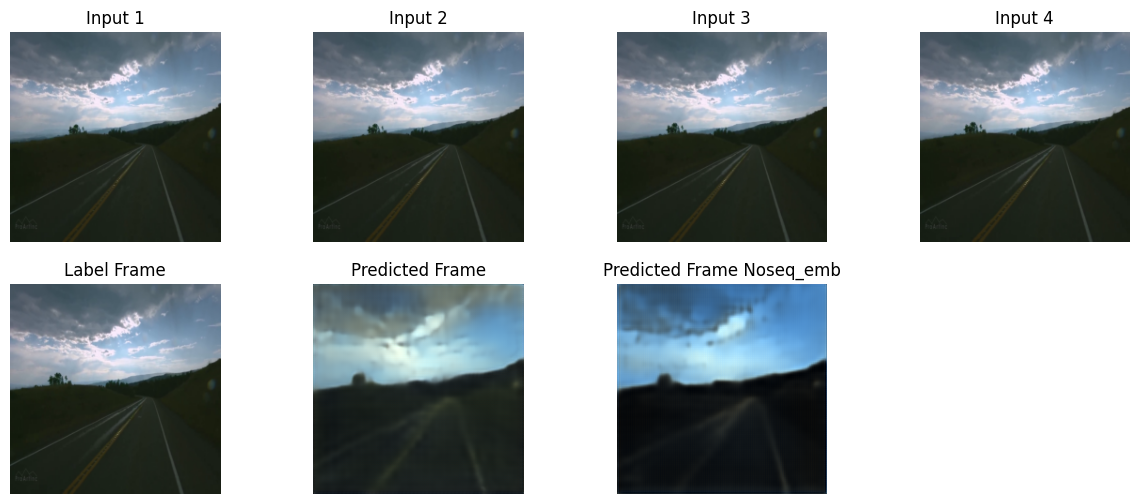

  4%|▍         | 1/25 [00:06<02:28,  6.17s/it]

Execution time baseline: 2.1921 seconds


  8%|▊         | 2/25 [00:11<02:14,  5.83s/it]

Execution time baseline: 2.1432 seconds


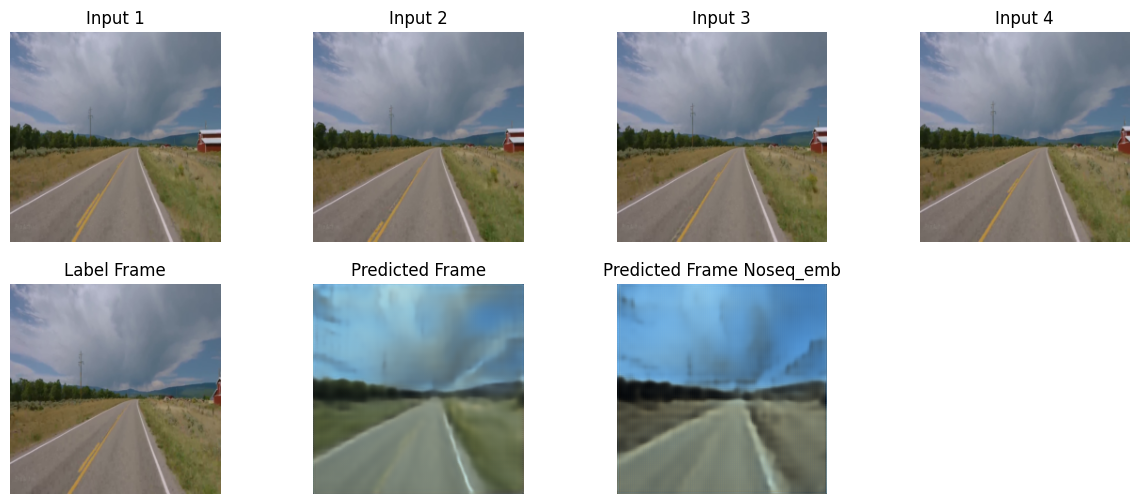

 12%|█▏        | 3/25 [00:18<02:12,  6.04s/it]

Execution time baseline: 2.1668 seconds


 16%|█▌        | 4/25 [00:23<02:03,  5.86s/it]

Execution time baseline: 2.1616 seconds


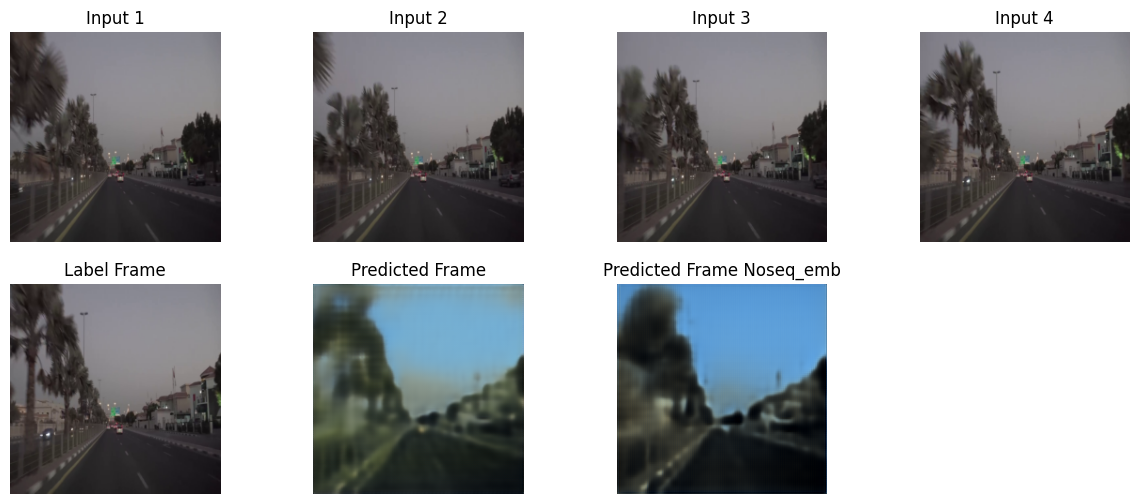

 20%|██        | 5/25 [00:29<01:59,  5.99s/it]

Execution time baseline: 2.1683 seconds


 24%|██▍       | 6/25 [00:35<01:51,  5.84s/it]

Execution time baseline: 2.1917 seconds


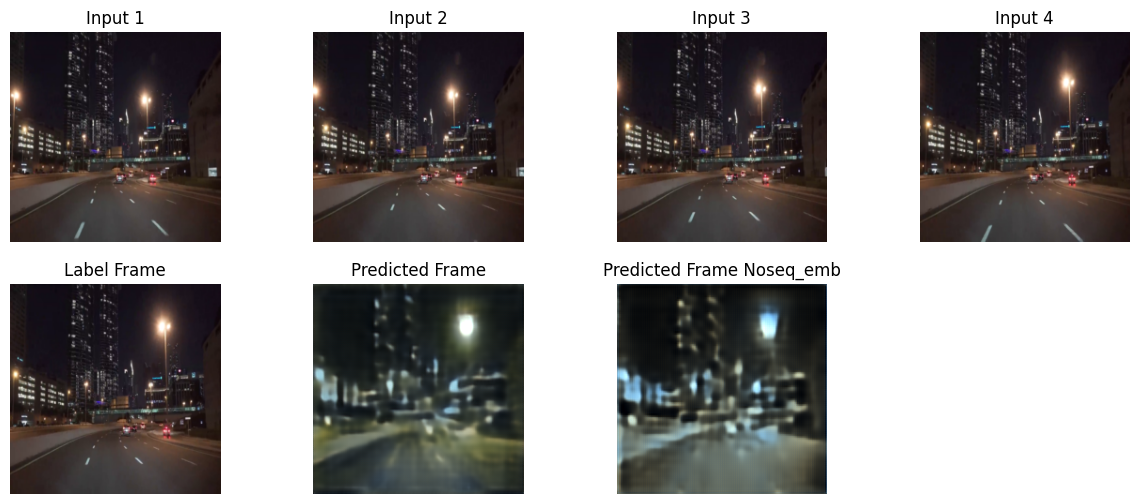

 28%|██▊       | 7/25 [00:41<01:48,  6.01s/it]

Execution time baseline: 2.2159 seconds


 32%|███▏      | 8/25 [00:47<01:40,  5.90s/it]

Execution time baseline: 2.2211 seconds


 36%|███▌      | 9/25 [00:53<01:34,  5.88s/it]

Execution time baseline: 2.1913 seconds


 40%|████      | 10/25 [00:58<01:26,  5.80s/it]

Execution time baseline: 2.1320 seconds


 44%|████▍     | 11/25 [01:04<01:20,  5.76s/it]

Execution time baseline: 2.1262 seconds


 48%|████▊     | 12/25 [01:10<01:14,  5.74s/it]

Execution time baseline: 2.1584 seconds


 52%|█████▏    | 13/25 [01:16<01:09,  5.77s/it]

Execution time baseline: 2.1299 seconds


 56%|█████▌    | 14/25 [01:21<01:03,  5.75s/it]

Execution time baseline: 2.1341 seconds


 60%|██████    | 15/25 [01:27<00:56,  5.66s/it]

Execution time baseline: 2.2452 seconds


 64%|██████▍   | 16/25 [01:32<00:50,  5.62s/it]

Execution time baseline: 2.1576 seconds


 68%|██████▊   | 17/25 [01:38<00:44,  5.57s/it]

Execution time baseline: 2.2111 seconds


 72%|███████▏  | 18/25 [01:43<00:39,  5.59s/it]

Execution time baseline: 2.2932 seconds


 76%|███████▌  | 19/25 [01:49<00:33,  5.64s/it]

Execution time baseline: 2.2323 seconds


 80%|████████  | 20/25 [01:55<00:28,  5.68s/it]

Execution time baseline: 2.1903 seconds


 84%|████████▍ | 21/25 [02:01<00:22,  5.66s/it]

Execution time baseline: 2.2415 seconds


 88%|████████▊ | 22/25 [02:06<00:16,  5.65s/it]

Execution time baseline: 2.1522 seconds


 92%|█████████▏| 23/25 [02:12<00:11,  5.60s/it]

Execution time baseline: 2.1448 seconds


 96%|█████████▌| 24/25 [02:17<00:05,  5.59s/it]

Execution time baseline: 2.1583 seconds


100%|██████████| 25/25 [02:23<00:00,  5.73s/it]

test loss for ITTR-seq [1/100], Loss: 0.052467573434114456, test Loss: 0.058844359517097475
test loss for ITTR [1/100], Loss: 0.05916869267821312, test Loss: 0.07238068595528603
test loss for ITTR-UNet [1/100], Loss: 0.3789502680301666, test Loss: 0.058844359517097475


In [16]:
from ITTR_transformer import ModifiedTransformerCNNForSegmentation
from ITTR_transformer_UNet import Transformer_UNet
from ITTR_transformer_NoSeqEmb import ITTR_Noseq
model_noseq = ITTR_Noseq().to(device)
model_noseq.load_state_dict(nn.load('/content/drive/MyDrive/Road_Analysis/saved_model_noseq.pth'))
model_noseq.eval()
model_UNet = Transformer_UNet().to(device)
model_UNet.load_state_dict(nn.load('/content/drive/MyDrive/Road_Analysis/saved_model_UNet.pth'))
model_UNet.eval()
model.eval()
with nn.no_grad():  # Gradient 계산을 방지
  total_loss = 0
  total_loss_noseq = 0
  total_loss_UNet = 0
  for b, (input_frames, label_frame) in tqdm(enumerate(test_loader), total=len(test_loader)):
      input_frames = input_frames.to(device)
      label_frame = label_frame.to(device)

      predictions = model(input_frames)
      loss = criterion(predictions, label_frame)
      total_loss += loss.item()

      predictions_noseq = model_noseq(input_frames)
      loss_noseq = criterion(predictions_noseq, label_frame)
      total_loss_noseq += loss_noseq.item()

      predictions_UNet = model_UNet(input_frames)
      loss_UNet = criterion(predictions_UNet, label_frame)
      total_loss_UNet += loss_UNet.item()

      # 인풋 프레임 시각화
      input_grid = make_grid(input_frames[0].to('cpu'), nrow=4)  # nrow는 input_frames의 개수에 따라 조정
      if b < 8 and b%2 == 0:
        fig = plt.figure(figsize=(15, 6))
        for i in range(4):
            ax = fig.add_subplot(2, 4, i+1)
            ax.imshow(input_frames[0][i].cpu().permute(1, 2, 0))
            ax.set_title(f'Input {i+1}')
            plt.axis('off')

        # 라벨 프레임 시각화
        ax = fig.add_subplot(2, 4, 5)
        plt.imshow(label_frame[0].cpu().permute(1, 2, 0))
        plt.title('Label Frame')
        plt.axis('off')

        # 예측 프레임 시각화
        ax = fig.add_subplot(2, 4, 6)
        plt.imshow(predictions[0].cpu().permute(1, 2, 0))
        plt.title('Predicted Frame')
        plt.axis('off')

        # Sharpening
        ax = fig.add_subplot(2, 4, 7)
        plt.imshow(predictions_noseq[0].cpu().permute(1, 2, 0))
        plt.title('Predicted Frame Noseq_emb')
        plt.axis('off')

        plt.show()

  avg_loss = total_loss / len(test_loader)
  print(f'test loss for ITTR-seq [{epoch+1}/{num_epochs}], Loss: {loss.item()}, test Loss: {avg_loss}')
  avg_loss = total_loss_noseq / len(test_loader)
  print(f'test loss for ITTR [{epoch+1}/{num_epochs}], Loss: {loss_noseq.item()}, test Loss: {avg_loss}')
  avg_loss = total_loss / len(test_loader)
  print(f'test loss for ITTR-UNet [{epoch+1}/{num_epochs}], Loss: {loss_UNet.item()}, test Loss: {avg_loss}')
